In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

In [ ]:
#Acces Dataset
data = '/content/drive/MyDrive/Portfolio/Bone/Data/Bone_Drilling_Data_Wahyu_Caesarendra.xlsx'



In [ ]:
# Baca dataset dari file Excel
df = pd.read_excel(data)

# Tampilkan beberapa baris pertama dari dataset untuk memastikan pembacaan berhasil
print(df.head())

   1  Layer1  0.0001  0.081626  0.064521  -0.095754
0  2  Layer1  0.0002  0.060684  0.081826  -0.123944
1  3  Layer1  0.0003  0.020763  0.055368  -0.144385
2  4  Layer1  0.0004 -0.027306  0.030179  -0.153339
3  5  Layer1  0.0005 -0.062263 -0.002259  -0.141035
4  6  Layer1  0.0006 -0.070618 -0.029059  -0.113784


# Data Visualization

In [ ]:
def plot_data(df, column_index, column_label, ylabel):
    # Pisahkan kolom yang berisi data getaran sumbu X, Y, atau Z
    data = df.iloc[:, column_index]
    labels = df.iloc[:, 1]  # Kolom Label

    # Pisahkan data untuk setiap layer
    layer1_data = df[labels == 'Layer1']
    layer2_data = df[labels == 'Layer2']
    layer3_data = df[labels == 'Layer3']

    # Plot gelombang amplitudo waktu untuk sumbu X, Y, atau Z berdasarkan setiap layer dengan zoom
    plt.figure(figsize=(12, 8))

    # Plot untuk Layer 1
    plt.subplot(3, 1, 1)
    plt.plot(layer1_data.iloc[:, 2], data[labels == 'Layer1'], color='blue')
    plt.title('Layer 1')
    plt.xlabel('Waktu')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xlim(0, 0.2)  # Zoom untuk Layer 1

    # Plot untuk Layer 2
    plt.subplot(3, 1, 2)
    plt.plot(layer2_data.iloc[:, 2], data[labels == 'Layer2'], color='green')
    plt.title('Layer 2')
    plt.xlabel('Waktu')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xlim(0, 0.2)  # Zoom untuk Layer 2

    # Plot untuk Layer 3
    plt.subplot(3, 1, 3)
    plt.plot(layer3_data.iloc[:, 2], data[labels == 'Layer3'], color='red')
    plt.title('Layer 3')
    plt.xlabel('Waktu')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xlim(0, 0.2)  # Zoom untuk Layer 3

    plt.tight_layout()
    plt.show()


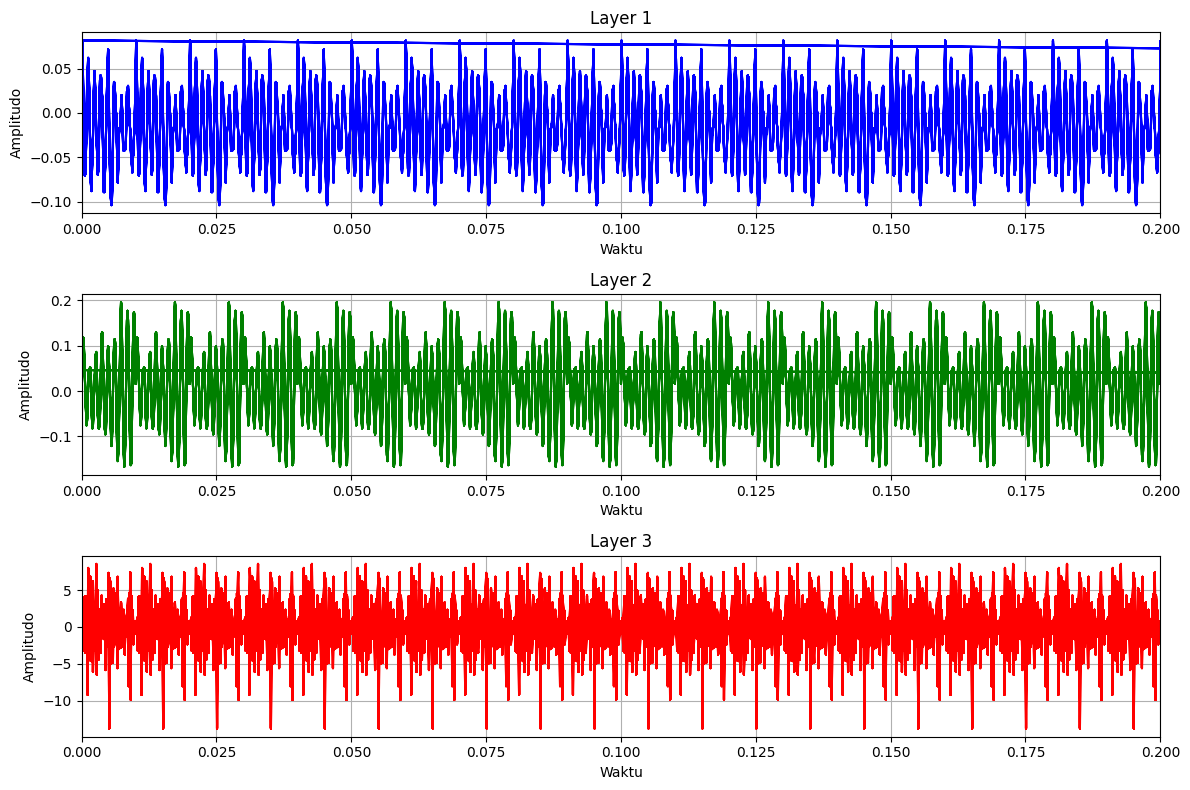

In [ ]:
# Plot data untuk sumbu X
plot_data(df, 3, 1, 'Amplitudo')

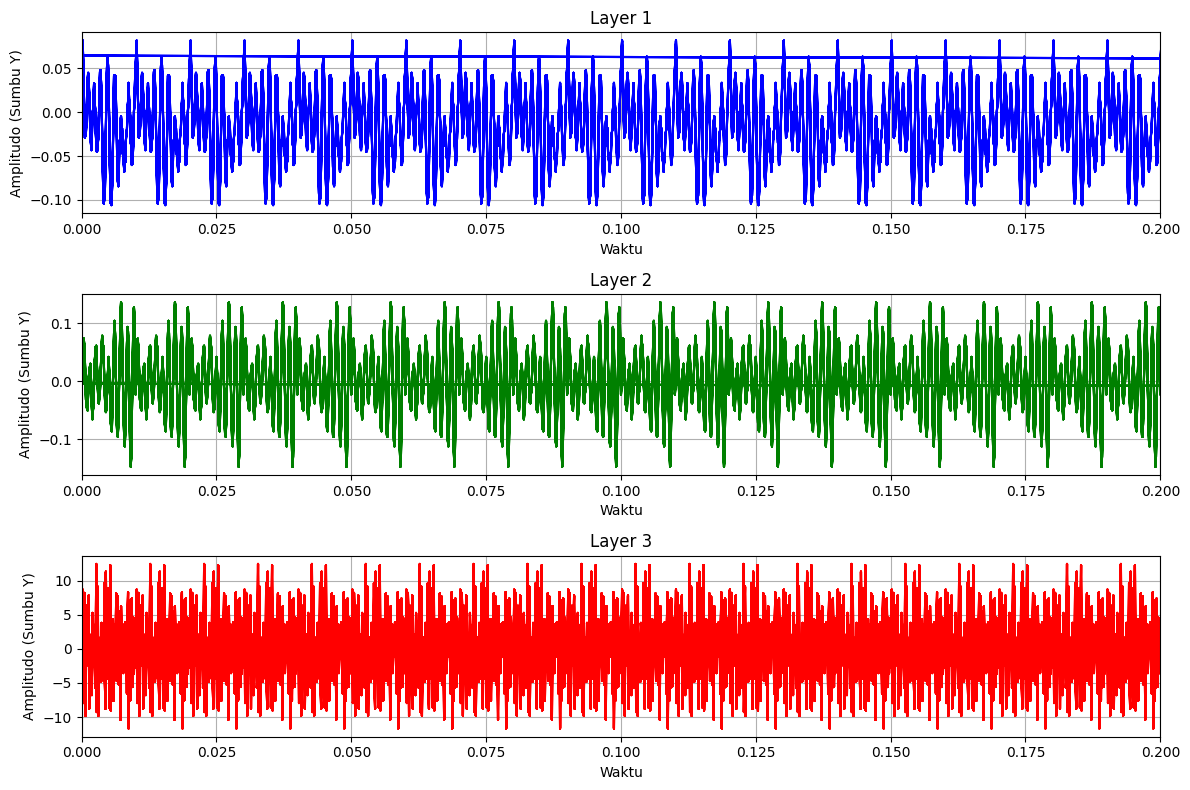

In [ ]:
# Plot data untuk sumbu Y
plot_data(df, 4, 1, 'Amplitudo (Sumbu Y)')

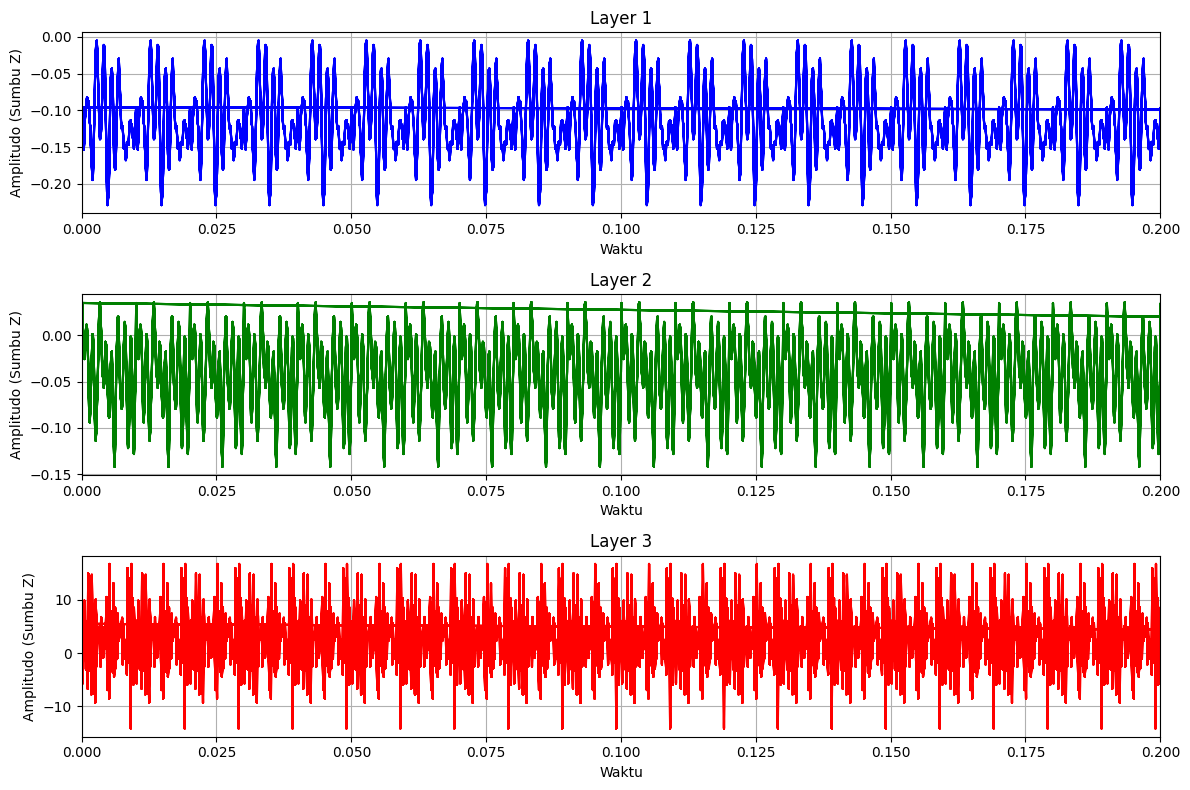

In [ ]:
# Plot data untuk sumbu Z
plot_data(df, 5, 1, 'Amplitudo (Sumbu Z)')

# Data Preprocessing

In [ ]:
# Pisahkan fitur dan label
X = df.iloc[:, 3:6].values  # Fitur: Data Getaran Sumbu X, Y, Z
y = pd.get_dummies(df.iloc[:, 1]).values  # Label: One-hot encoding untuk Layer


# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
X[5]

array([-0.067861, -0.026557, -0.10338 ])

In [ ]:
y[5]

array([ True, False, False])

# Model Building Using LSTM

In [ ]:
# Callback untuk mengatur learning rate
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Atur learning rate berdasarkan jadwal yang diberikan
        scheduled_lr = self.schedule(epoch)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f'\nEpoch {epoch+1}: Learning rate is set to {scheduled_lr}')

def lr_schedule(epoch):
    initial_learning_rate = 0.01
    decay_rate = 0.9
    decay_steps = 5
    calculated_lr = initial_learning_rate * (decay_rate ** (epoch // decay_steps))
    return calculated_lr


# Input layer
input_layer = tf.keras.layers.Input(shape=(X_train_scaled.shape[1], 1))

# LSTM layer
lstm_layer = tf.keras.layers.LSTM(32, return_sequences=True)(input_layer)
lstm_layer2 = tf.keras.layers.LSTM(32)(lstm_layer)


# Flatten layer
flatten_layer = tf.keras.layers.Flatten()(lstm_layer2)

# Dense layers
output_layer = tf.keras.layers.Dense(3, activation='softmax')(flatten_layer)

# Combine layers into model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 12771 (49.89 KB)
Trainable params: 12771 (49.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


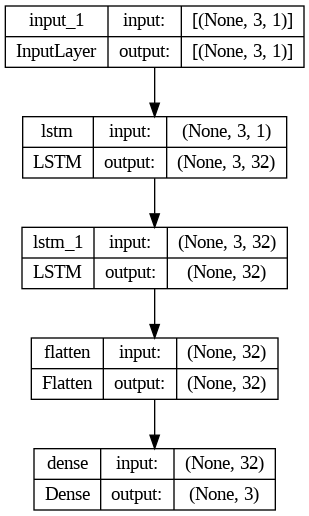

In [ ]:
# Buat plot dari model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model based on validation loss
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_best_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            verbose=1)

# Callback untuk mengatur learning rate
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with validation data
# Train the model with Early Stopping and ModelCheckpoint callbacks
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, learning_rate_scheduler])


Epoch 1: Learning rate is set to 0.01
Epoch 1/50
2994/3000 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.8802
Epoch 1: val_loss improved from inf to 0.17226, saving model to best_model.h5
3000/3000 [==============================] - 25s 7ms/step - loss: 0.2488 - accuracy: 0.8802 - val_loss: 0.1723 - val_accuracy: 0.9330

Epoch 2: Learning rate is set to 0.01
Epoch 2/50
  19/3000 [..............................] - ETA: 17s - loss: 0.1964 - accuracy: 0.9161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2994/3000 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9277
Epoch 2: val_loss did not improve from 0.17226
3000/3000 [==============================] - 20s 7ms/step - loss: 0.1635 - accuracy: 0.9277 - val_loss: 0.1787 - val_accuracy: 0.9225

Epoch 3: Learning rate is set to 0.01
Epoch 3/50
3000/3000 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9357
Epoch 3: val_loss improved from 0.17226 to 0.11552, saving model to best_model.h5
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1414 - accuracy: 0.9357 - val_loss: 0.1155 - val_accuracy: 0.9454

Epoch 4: Learning rate is set to 0.01
Epoch 4/50
2999/3000 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9443
Epoch 4: val_loss improved from 0.11552 to 0.10436, saving model to best_model.h5
3000/3000 [==============================] - 20s 7ms/step - loss: 0.1226 - accuracy: 0.9443 - val_loss: 0.1044 - val_accuracy: 0.9470

Epoch 5: Learning rate is

# Model Evaluation

In [ ]:
def evaluate_and_plot(history, X_test_scaled, y_test):
    # Evaluasi model menggunakan data uji
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    # Plot akurasi dan loss dari history model
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


938/938 [==============================] - 4s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Test Loss: 0.0015851538628339767
Test Accuracy: 1.0


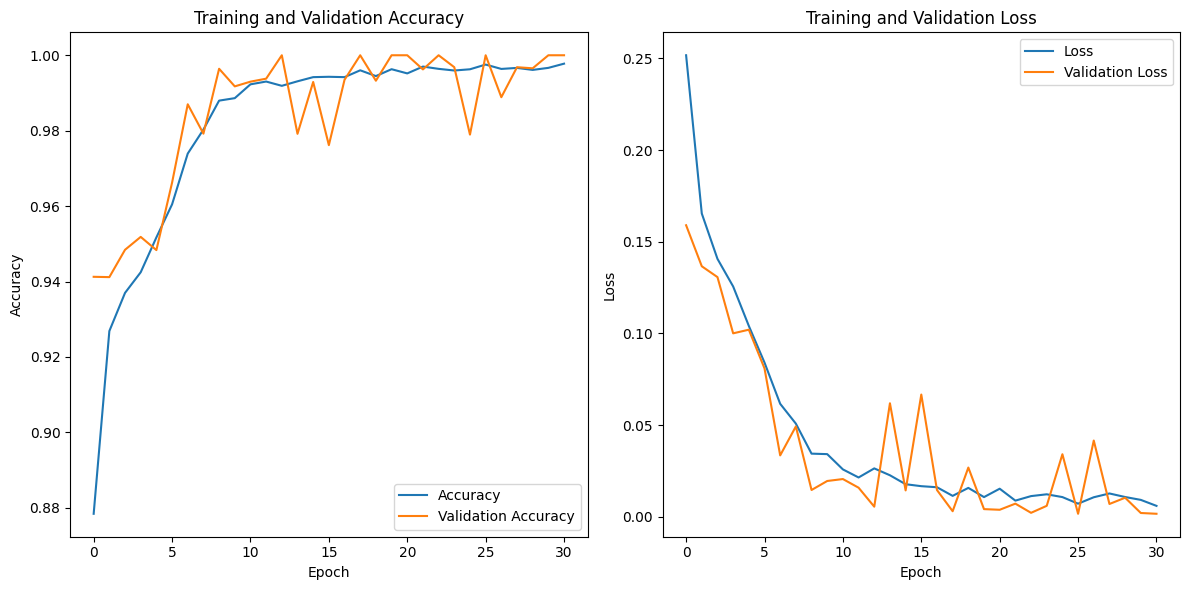

In [ ]:
evaluate_and_plot(history, X_test_scaled, y_test)

In [ ]:
#Load Best Model
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")

938/938 [==============================] - 2s 2ms/step
Confusion Matrix:
[[10038     0     0]
 [    0  9968     0]
 [    0     0  9994]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10038
           1       1.00      1.00      1.00      9968
           2       1.00      1.00      1.00      9994

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



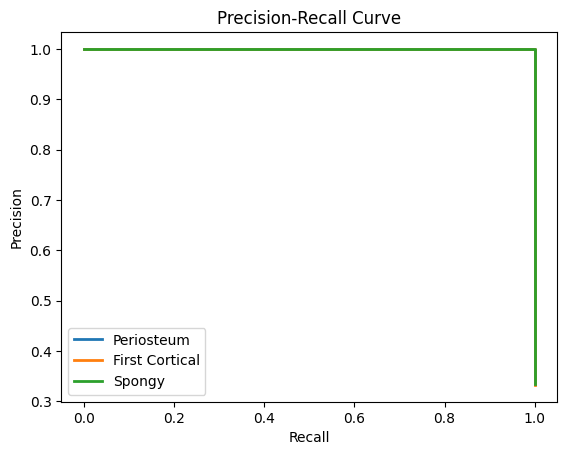

In [ ]:
# Laporan evaluasi tambahan
y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_true_labels, y_pred_labels))
print('\nClassification Report:')
print(classification_report(y_true_labels, y_pred_labels))

# Precision-Recall Curve
precision = dict()
recall = dict()
for i, class_name in enumerate(['Periosteum', 'First Cortical', 'Spongy']):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.savefig('precision_recall_curve.png') # Menyimpan sebagai PNG
plt.show()


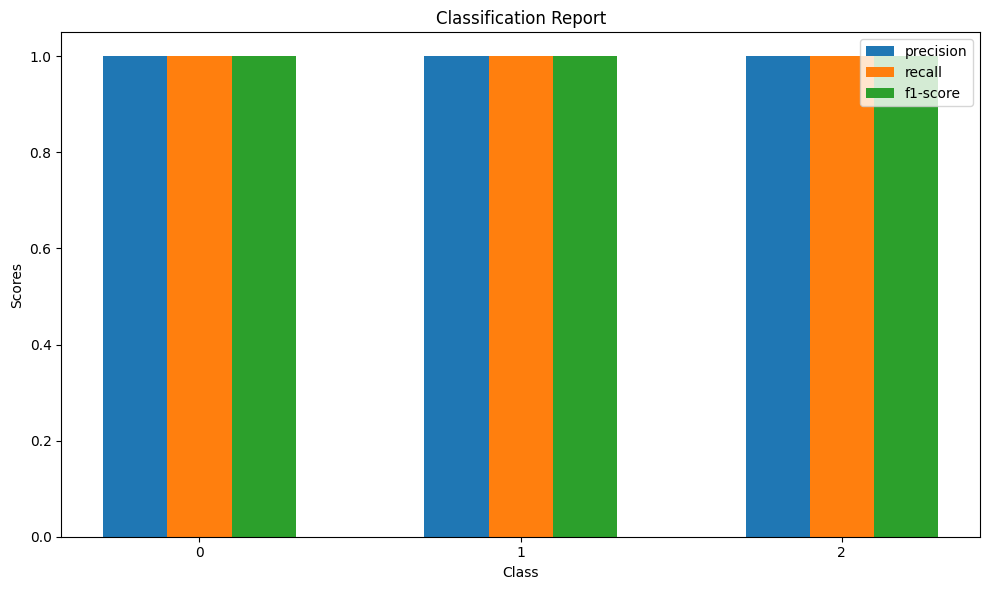

In [ ]:
# Laporan evaluasi model
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Ekstraksi nilai precision, recall, f1-score, dan support
classes = [str(i) for i in range(len(report) - 3)]  # Menggunakan nomor kelas sebagai label
metrics = ['precision', 'recall', 'f1-score', 'support']

scores = {}
for metric in metrics:
    scores[metric] = [report[cls][metric] for cls in classes]

# Plot precision, recall, dan f1-score untuk setiap kelas
fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(classes))
bar_width = 0.2

for i, metric in enumerate(metrics[:-1]):
    ax.bar([x + i * bar_width for x in index], scores[metric], bar_width, label=metric)

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.savefig('classification_report.png')  # Menyimpan sebagai PNG
plt.show()


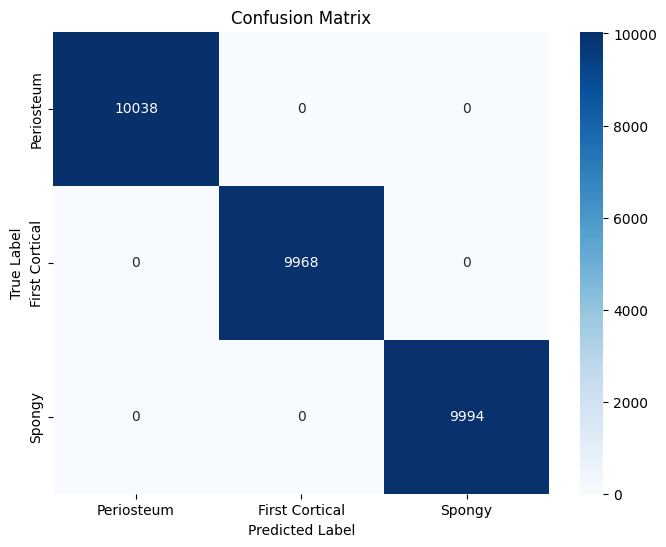

In [ ]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Periosteum', 'First Cortical', 'Spongy'], yticklabels=['Periosteum', 'First Cortical', 'Spongy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png') # Menyimpan sebagai PNG
plt.show()

# Recommendations
While the current LSTM model performs well, there are several recommendations to further improve its performance and applicability:

- Increase Data Diversity: Collect more data from different drilling conditions and bone types to improve model generalization.
- Experiment with Model Architectures: Try different LSTM architectures, such as stacking multiple LSTM layers or combining LSTM with other types of neural networks (e.g., CNN-LSTM) for better feature extraction.
- Feature Engineering: Explore additional features such as the rate of change in vibrations, energy of the signal, or frequency domain features to enhance the model’s ability to distinguish between layers.